# Amazon, modelo supervisado

## Importar

In [1]:
# %load basic
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',200)
pd.options.display.float_format = '{:.2f}'.format
liga = '/home/ef/Documents/Diplomado/Amazon/data/'
start = time.time()
os.listdir(liga)

['raw',
 'df_sentim.csv',
 'sentim.csv',
 'df.csv',
 'df_cluster.csv',
 'csv',
 'FitRec']

In [2]:
df = pd.read_csv(liga + 'df_cluster.csv')
df = df.sample(frac = .1).reset_index(drop = True)
print(df.shape)
df.sample(4)

(55531, 59)


,verified,style,category,Mes,DiaSem,Anio,reviewText_long,reviewText_n_words,reviewText_relevant,neg,neu,pos,compound,overall,book_cv,case_cv,character_cv,five_cv,game_cv,get_cv,good_cv,great_cv,like_cv,love_cv,movie_cv,much_cv,one_cv,phone_cv,read_cv,really_cv,star_cv,story_cv,time_cv,well_cv,work_cv,would_cv,book_tv,case_tv,character_tv,five_tv,game_tv,get_tv,good_tv,great_tv,like_tv,love_tv,movie_tv,much_tv,one_tv,phone_tv,read_tv,really_tv,star_tv,story_tv,time_tv,well_tv,work_tv,would_tv,Cluster
29651,True,No_especifica,movies_and_tv,ago,dom,2015,15.00,3.00,0.94,0.00,0.47,0.54,0.32,4.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,B
18374,True,No_especifica,movies_and_tv,may,jue,2015,1479.00,266.00,0.61,0.15,0.67,0.18,0.85,5.00,0,0,0,0,0,3,0,1,0,0,1,0,0,0,0,2,0,0,0,1,3,0,0.00,0.00,0.00,0.00,0.00,0.59,0.00,0.15,0.00,0.00,0.20,0.00,0.00,0.00,0.00,0.40,0.00,0.00,0.00,0.20,0.62,0.00,D
25987,True,No_especifica,kindle_store,oct,jue,2013,275.00,48.00,0.61,0.06,0.51,0.43,0.92,5.00,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.40,0.00,0.00,0.00,0.44,D
7431,True,Sí,cell_phones_and_accessories,dic,jue,2012,146.00,29.00,0.63,0.07,0.44,0.49,0.86,4.00,0,2,0,0,0,0,0,0,1,0,0,0,0,3,0,1,0,0,0,1,0,0,0.00,0.52,0.00,0.00,0.00,0.00,0.00,0.00,0.21,0.00,0.00,0.00,0.00,0.75,0.00,0.25,0.00,0.00,0.00,0.24,0.00,0.00,D


## Funciones

In [3]:
import math
def time_exp(x):
    print(str(int(math.floor(x/60))
             ) + " minutos con " + '{:.2f}'.format(60*(x/60 - math.floor(x/60))
                                                  ) + " segundos")

In [4]:
#Tono para cuando termina el script
from IPython.lib.display import Audio
import numpy as np

def tono(a = 1000, b = 700, play_time_seconds = 2, framerate = 4410,):
    t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)*np.pi
    return Audio(np.sin(a*t) + np.sin(b*t), rate = framerate, autoplay=True)

## Caso continuo

### Preprocesamiento

In [5]:
target = 'compound'
words = [x for x in df.columns if x.endswith('_tv') or x.endswith('_cv')]
num = [x for x in df.describe().columns if x not in words + [target] + ['neg','neu','pos']]
cat = [x for x in df.columns if x not in words + num + [target] + ['neg','neu','pos']]

df = df[cat + 
        num + 
        words + 
        [target]].copy()
X = df.iloc[:,:-1]
y = df[target].values

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.7, 
                                                    random_state = 22)

In [7]:
#Encoder para categóricas
from category_encoders.cat_boost import CatBoostEncoder
encod = CatBoostEncoder()

#Escala para numéricas
from sklearn.preprocessing import MinMaxScaler
mm_x = MinMaxScaler()

#Se aplicará transformación para cada tipo de columnas
from sklearn.compose import ColumnTransformer
prep = ColumnTransformer(transformers=[('OHE', encod, cat),
                                       ('Scale', mm_x, num)])

### Modelo

In [8]:
from xgboost.sklearn import XGBRegressor
xgb = XGBRegressor()

param_xgb = {'learning_rate':[x/100 for x in range(1,111)],
             'n_estimators':[x for x in range(1,111)],
             'max_depth':[x for x in range(1,11)], 
             'min_child_weight':[x/10 for x in range(1,111)],
             'subsample':[x/100 for x in range(1,111)], 
             'colsample_bytree':[x/100 for x in range(1,111)], 
            }

from sklearn.model_selection import RandomizedSearchCV
search_xgb = RandomizedSearchCV(param_distributions = param_xgb, 
                                cv = 4, 
                                n_jobs = -1, 
                                scoring = 'r2', 
                                estimator = xgb, 
                                verbose = 5,
                                n_iter = 100,
                                random_state = 22)

In [9]:
from sklearn.pipeline import Pipeline
modelo = Pipeline(steps=[('PCA', prep),
                         ('XGBoost', search_xgb)])

modelo.fit(X_train,y_train).score(X_test,y_test)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.2min finished


0.6754763443821473

### Validación

<AxesSubplot:>

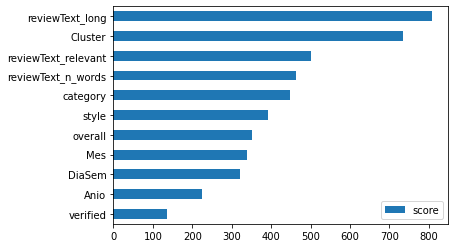

In [10]:
#Qué variables aportan más al modelo?
importance = modelo[1].best_estimator_.get_booster().get_score(importance_type='weight')

data = pd.DataFrame(data = list(importance.values()),
                    index = [(X.columns)[int(x[1:])] for x in importance.keys()], 
                    columns = ["score"]).sort_values(by = "score")
data.plot(kind='barh')

### Conservar modelo

In [11]:
#Exportar modelo
import pickle
with open('modelo_amazon_continuo.pkl', "wb") as f:
    pickle.dump(modelo, f)

In [12]:
#Importar modelo
import pickle    
with open('modelo_amazon_continuo.pkl', "rb") as f:
    modelo = pickle.load(f)

## Fin

In [13]:
#Tiempo total para correr el notebook
end = time.time()
time_exp(end - start)
tono(play_time_seconds = 1)

3 minutos con 23.85 segundos
